In [2]:
setwd("..")

In [3]:
# change default figure size
options(repr.plot.width=15, repr.plot.height=7)
# disable scientific notation (for plot axes)
options(scipen = 999)

In [5]:
library(readr)
library(dplyr)
library(tibble)
library(tidyr)
library(purrr)
library(ggplot2)
library(ggpubr)

## Functions

In [1]:
# transform the square correlation matrix into long format
cor_to_long <- function(m){
    #df <- m %>%
    #  as.data.frame %>% 
    #  tibble::rownames_to_column() %>% 
    #  tidyr::pivot_longer(-rowname) %>%
    #  select(row = rowname, col = name, corr = value) %>%
    #  filter(row != col)
    df <- data.frame(row=rownames(m)[row(m)], col=colnames(m)[col(m)], corr=c(m)) %>%
      filter(row != col)
    df <- df %>% 
      mutate(row = as.numeric(row)) %>% # convery minhash back to numeric to perserve joins later
      mutate(col = as.numeric(row))
} 

## Read in hash map and label with operons

In [6]:
pa14_hash_map <- read_csv("outputs/txomes_sourmash_sketch_singleton/pa14.csv", show_col_types = F)

In [7]:
pa14_operons <- read_csv("https://raw.githubusercontent.com/greenelab/core-accessory-interactome/master/data/metadata/PA14-operons-2021-07-19.csv", show_col_types = F)

In [8]:
pa14_transcript_to_gene <- read_csv("https://osf.io/ema5c/download", skip = 1, col_names = c("tmp", "transcript_name", "locus_tag"), show_col_types = F) %>%
  select(-tmp)

In [9]:
pa14_hash_map <- pa14_hash_map %>%
  mutate(transcript_name = gsub(" .*", "", name)) %>%
  left_join(pa14_transcript_to_gene, by = "transcript_name") %>%
  left_join(pa14_operons, by = "locus_tag")

In [21]:
pa14_hash_map_operon <- pa14_hash_map %>%
  filter(!is.na(`operon-id`))

pa14_hash_map_operon_small <- pa14_hash_map_operon %>%
  select(minhash, operon_id = `operon-id`) %>%
  distinct()

## Filter our "rare" k-mers

DESeq2 normalization was done with minimal filtering, keeping all k-mers that were in at least 10 data sets. 
Further filter out "rare" k-mers so that corelations can be performed without exhausting vector memory.

In [13]:
# read in metadata, which records library:strain mapping
metadata <- read_tsv("inputs/metadata.tsv", show_col_types = F)
metadata_pa14 <- metadata %>%
  dplyr::filter(strain_type == "PA14")

# read in only pa14 files
pa14_files <- paste0("outputs/srx_sourmash_sketch_filtered_csv/", metadata_pa14$experiment, "_k21.csv")
raw_pa14_kmers_long <- pa14_files %>%
  purrr::set_names() %>%
  purrr::map_dfr(read_csv, skip = 1, col_names = c("minhash", "abund"), show_col_types = F, .id = "sample") %>%  # read in sketches
  dplyr::mutate(sample = gsub("_k21\\.csv", "", basename(sample)))

# pivot from long to wide; shares minhash index
raw_pa14_kmers <- raw_pa14_kmers_long %>%
  pivot_wider(id_cols = minhash, names_from = sample, values_from = abund) %>%
  replace(is.na(.), 0) %>% # replace NAs with zero abund
  column_to_rownames("minhash")

In [14]:
# make a presence absense DF to filter to common k-mers
raw_pa14_kmers_pa <- raw_pa14_kmers %>%
  mutate_if(is.numeric, ~1 * (. != 0))

In [26]:
# define a vector of kmers to keep; limit to ones that are present in many samples
keep_kmers <- rownames(raw_pa14_kmers_pa)[rowSums(raw_pa14_kmers_pa) > 100]

length(keep_kmers)

[1] 7601

## Correlations with DESeq2 normalized hashes

### Mean ratio normalization

In [10]:
mrnorm_pa14_kmers <- read_csv("sandbox/202203_normalize/pa14_mrnorm_kmers.csv")

Rows: 67286 Columns: 546

── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (546): minhash, SRX4641866, SRX4641865, SRX4641864, SRX4641863, SRX46418...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [29]:
# do log norm correlation analysis
tmp <- mrnorm_pa14_kmers %>%
  filter(minhash %in% keep_kmers) %>%
  column_to_rownames("minhash") %>%
  t()

mrnorm_pa14_kmers_cor <- cor(tmp, method = "pearson")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



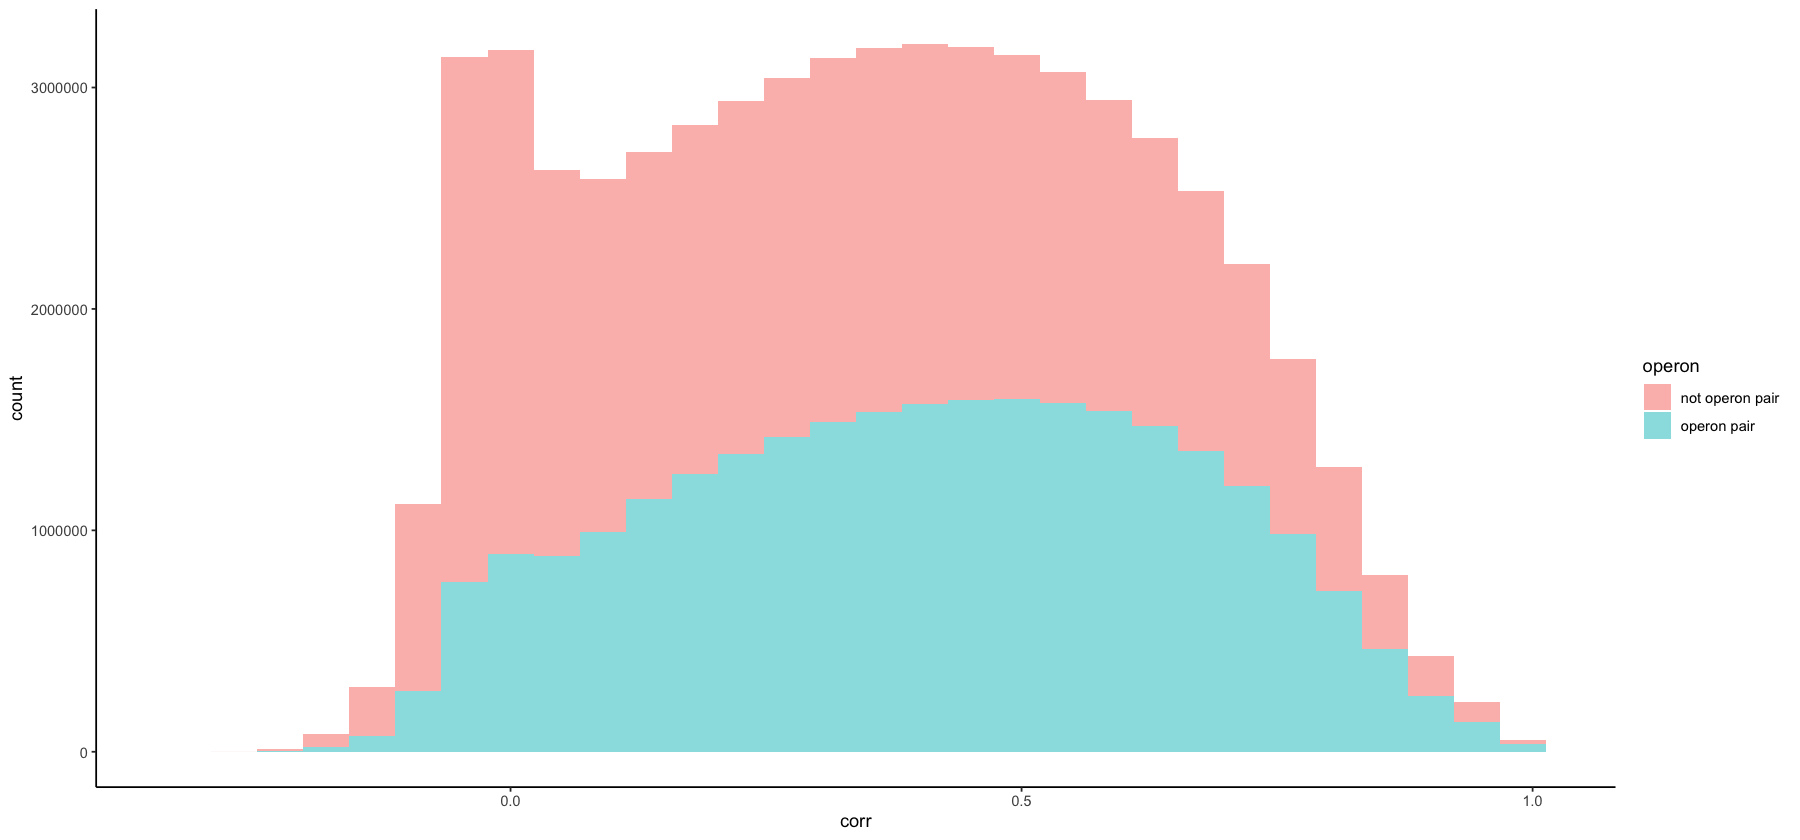

In [30]:
mrnorm_pa14_kmers_cor_df <- cor_to_long(mrnorm_pa14_kmers_cor) %>%
  left_join(pa14_hash_map_operon_small, by = c("row" = "minhash")) %>% # determine which operon, if any, the row is part of
  select(row, col, corr, operon_id_row = operon_id) %>% # record operon identity of row
  left_join(pa14_hash_map_operon_small, by = c("col" = "minhash")) %>% # determine which operon the col is part of
  select(row, col, corr, operon_id_row, operon_id_col = operon_id) %>% # record operon identity of col
  mutate(operon = ifelse(operon_id_row == operon_id_col, "operon pair", "not operon pair")) %>% # label operon pairs
  mutate(operon = ifelse(is.na(operon), "not operon pair", operon))

ggplot(mrnorm_pa14_kmers_cor_df, aes(x = corr, fill = operon)) +
  geom_histogram(alpha = .5) +
  theme_classic()

### variance stabilized transformation

In [23]:
vstnorm_pa14_kmers <- read_csv("sandbox/202203_normalize/pa14_vstnorm_kmers.csv")

Rows: 67286 Columns: 546

── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (546): minhash, SRX4641866, SRX4641865, SRX4641864, SRX4641863, SRX46418...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [27]:
# do log norm correlation analysis
tmp <- vstnorm_pa14_kmers %>%
  filter(minhash %in% keep_kmers) %>%
  column_to_rownames("minhash") %>%
  t()

vstnorm_pa14_kmers_cor <- cor(tmp, method = "pearson")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



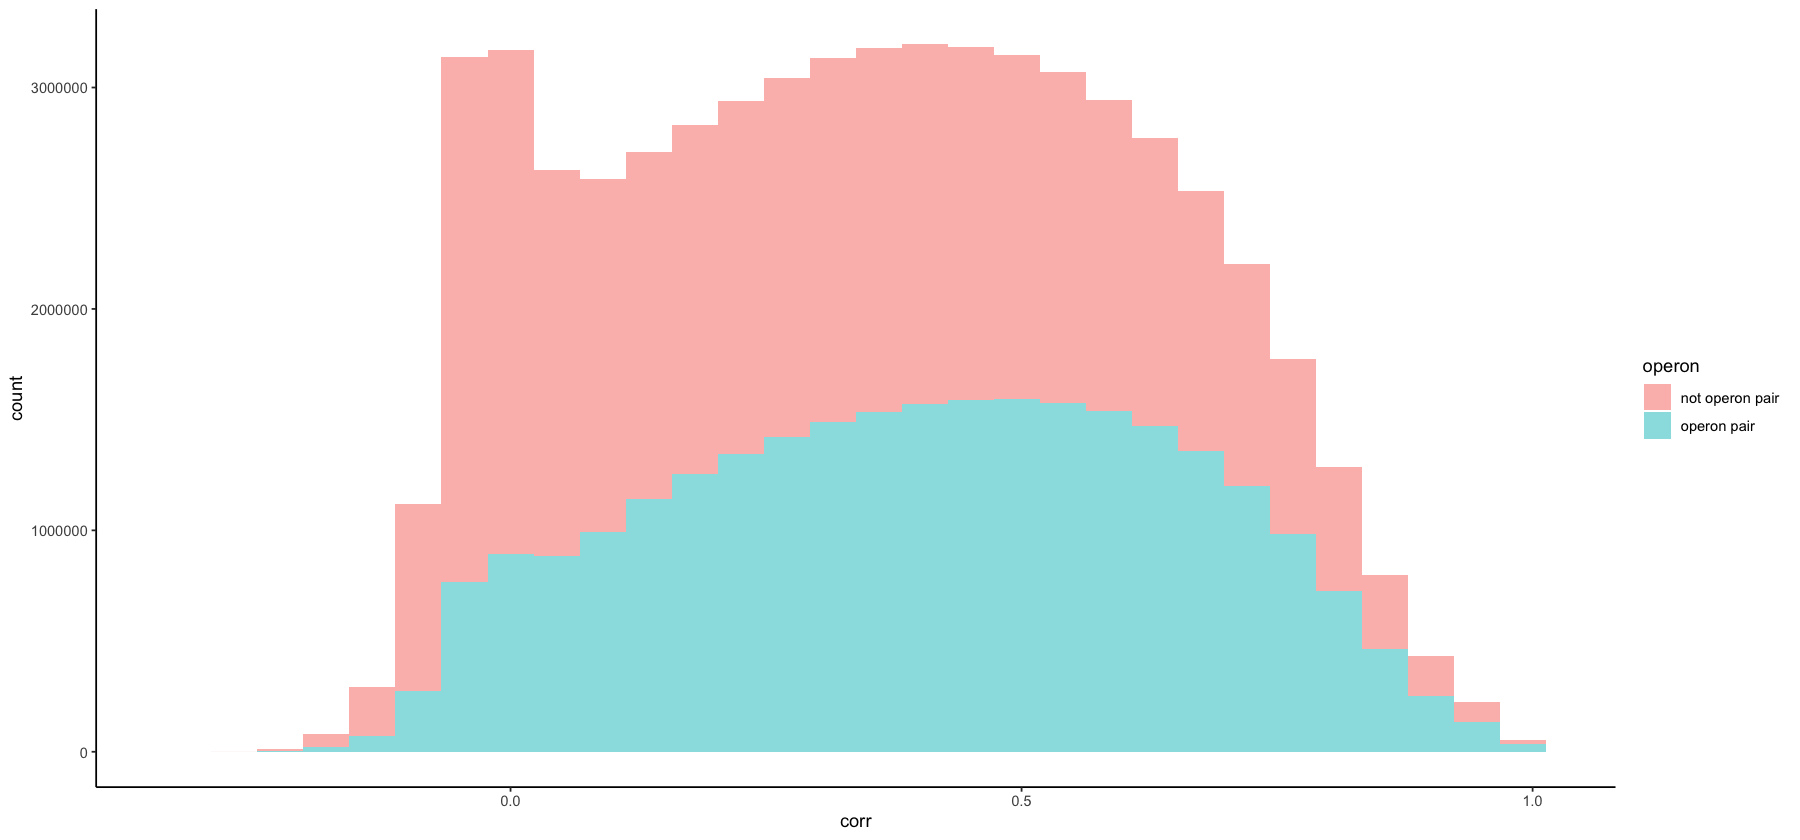

In [28]:
vstnorm_pa14_kmers_cor_df <- cor_to_long(vstnorm_pa14_kmers_cor) %>%
  left_join(pa14_hash_map_operon_small, by = c("row" = "minhash")) %>% # determine which operon, if any, the row is part of
  select(row, col, corr, operon_id_row = operon_id) %>% # record operon identity of row
  left_join(pa14_hash_map_operon_small, by = c("col" = "minhash")) %>% # determine which operon the col is part of
  select(row, col, corr, operon_id_row, operon_id_col = operon_id) %>% # record operon identity of col
  mutate(operon = ifelse(operon_id_row == operon_id_col, "operon pair", "not operon pair")) %>% # label operon pairs
  mutate(operon = ifelse(is.na(operon), "not operon pair", operon))

ggplot(vstnorm_pa14_kmers_cor_df, aes(x = corr, fill = operon)) +
  geom_histogram(alpha = .5) +
  theme_classic()